In [1]:
import os

# takes care of annoying TF-GPU warnings
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [2]:
# very useful for managing wandb runs: https://stackoverflow.com/questions/71106179/log-two-model-runs-with-keras-wandb
import wandb
from wandb.keras import WandbCallback
os.environ["WANDB_SILENT"] = "true"

#### RNN: Formula Label Prediction 

In [3]:
import numpy as np 
import pandas as pd
from pathlib import Path 

import tensorflow as tf

from tensorflow.keras import layers 
from tensorflow.keras import utils

import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import datetime

tfds.disable_progress_bar()

In [4]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_"+metric], "")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_"+metric])

#### Import Data and Preprocess Dataframe

In [5]:
def preprocess_data(corpus,
                    irrelevant_features=["mtype",]):
    # drop irrelevant columns
    corpus.drop(irrelevant_features, inplace=True, axis=1)

    # filter strings
    def process_cell(cell_str):
        stripped_f_str = cell_str[1:-1].replace("\\\\", "\\")
        f_list = stripped_f_str.split(",")
        f_list = [token.replace("'", "").replace(" ", "") for token in f_list]
        f_list = ["{" if token == "\\{" else token for token in f_list]
        f_list = ["}" if token == "\\}" else token for token in f_list]
        cell_str = " ".join(f_list)
        return cell_str

    corpus["tokens"] = corpus["tokens"].map(process_cell)

In [6]:
data_p = Path("data/") / "bin_class_data_TOKENIZED_V1.csv"
data = pd.read_csv(data_p)
preprocess_data(data)
data.head()


,tokens,label
0,{ a },1
1,3 r,1
2,f,1
3,\binom { 4 } { 4 },1
4,1,1


In [7]:
DATASET_SIZE = 11000
data_as_ds = tf.data.Dataset.from_tensor_slices((data["tokens"], data["label"])) 
test_dataset = data_as_ds.take(1000)
train_dataset = data_as_ds.skip(1000)

##### Setup and Data Preparation

In [8]:
for example, label in train_dataset.take(1):
    print("text: ", example.numpy())
    print("label: ", label.numpy())

text:  b'g ( x ) = x ^ 2 + 2 x'
label:  1


In [9]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

##### Text Encoding

In [10]:
def create_encoder(output_mode_str, n_grams):
    VOCAB_SIZE = 1000
    encoder = tf.keras.layers.TextVectorization(
        standardize=None,
        output_mode=output_mode_str,
        ngrams = n_grams,
        split="whitespace",
        max_tokens=VOCAB_SIZE)
    encoder.adapt(train_dataset.map(lambda tokens, label: tokens)) # removes the label column through transformation: text, label -> text
    return encoder

##### Representation 1: Use integer indices encoding

In [11]:
encoder_int = create_encoder("int", None)
vocab = np.array(encoder_int.get_vocabulary())
vocab[:200]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


array(['', '[UNK]', 'f', 'x', '1', '2', '}', '{', '(', ')', '^', '+', ':',
       '-', '\\to', '=', '3', 'g', 'n', 'a', 'A', '0', '4', '\\frac', 'b',
       'B', '\\rightarrow', 'X', '5', 'y', '\\mathbb{R}', '\\mathbb{N}',
       '\\mathbb', 'Y', '6', 'h', 'R', 'c', '/', '7', '\\colon', '9', 'p',
       'k', 't', 'F', '8', 'm', 'i', 'S', 'd', 'e', 'N', '\\times', 'z',
       's', 'C', 'q', 'r', ']', '\\circ', '[', '\\mathbb{Z}', '\\dfrac',
       '\\mathbb{Q}', '\\cdot', '\\sin', '\\cup', 'T', 'u', 'Z', 'P', '!',
       'M', '\\cap', 'G', 'E', 'D', 'U', 'Q', 'I', 'v', 'w', 'j', 'H',
       '*', '\\varnothing', 'V', '\\cos', 'W', '\\exp', 'o', '\\arcsin',
       '\\binom', 'l', '\\mathbb{C}', 'K', '\\ln', 'J', '\\arctan', 'L',
       '\\cot', '\\cosh', 'O', '\\tanh', '\\arccos', '\\tfrac', '\\log',
       '\\div', '\\sinh', '\\dbinom'], dtype='<U11')

In [12]:
encoded_example = encoder_int(example).numpy()
print(example)
print(encoded_example)

tf.Tensor(b'g ( x ) = x ^ 2 + 2 x', shape=(), dtype=string)
[17  8  3  9 15  3 10  5 11  5  3]


In [13]:
print("Original: ", example.numpy())
print("After reverse lookup: ", " ".join(vocab[encoded_example]))

Original:  b'g ( x ) = x ^ 2 + 2 x'
After reverse lookup:  g ( x ) = x ^ 2 + 2 x


##### Representation 2: Binary Count Vectorizer

In [14]:
encoder_multi_hot = create_encoder("multi_hot", None)
vocab = np.array(encoder_multi_hot.get_vocabulary())
vocab[:200]

array(['[UNK]', 'f', 'x', '1', '2', '}', '{', '(', ')', '^', '+', ':',
       '-', '\\to', '=', '3', 'g', 'n', 'a', 'A', '0', '4', '\\frac', 'b',
       'B', '\\rightarrow', 'X', '5', 'y', '\\mathbb{R}', '\\mathbb{N}',
       '\\mathbb', 'Y', '6', 'h', 'R', 'c', '/', '7', '\\colon', '9', 'p',
       'k', 't', 'F', '8', 'm', 'i', 'S', 'd', 'e', 'N', '\\times', 'z',
       's', 'C', 'q', 'r', ']', '\\circ', '[', '\\mathbb{Z}', '\\dfrac',
       '\\mathbb{Q}', '\\cdot', '\\sin', '\\cup', 'T', 'u', 'Z', 'P', '!',
       'M', '\\cap', 'G', 'E', 'D', 'U', 'Q', 'I', 'v', 'w', 'j', 'H',
       '*', '\\varnothing', 'V', '\\cos', 'W', '\\exp', 'o', '\\arcsin',
       '\\binom', 'l', '\\mathbb{C}', 'K', '\\ln', 'J', '\\arctan', 'L',
       '\\cot', '\\cosh', 'O', '\\tanh', '\\arccos', '\\tfrac', '\\log',
       '\\div', '\\sinh', '\\dbinom'], dtype='<U11')

In [15]:
encoded_example = encoder_multi_hot(example).numpy()
print(example)
print(encoded_example)

tf.Tensor(b'g ( x ) = x ^ 2 + 2 x', shape=(), dtype=string)
[0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


##### Representation 3: Frequency Count Vectorizer

In [16]:
encoder_count = create_encoder("count", None)
vocab = np.array(encoder_count.get_vocabulary())
vocab[:200]

array(['[UNK]', 'f', 'x', '1', '2', '}', '{', '(', ')', '^', '+', ':',
       '-', '\\to', '=', '3', 'g', 'n', 'a', 'A', '0', '4', '\\frac', 'b',
       'B', '\\rightarrow', 'X', '5', 'y', '\\mathbb{R}', '\\mathbb{N}',
       '\\mathbb', 'Y', '6', 'h', 'R', 'c', '/', '7', '\\colon', '9', 'p',
       'k', 't', 'F', '8', 'm', 'i', 'S', 'd', 'e', 'N', '\\times', 'z',
       's', 'C', 'q', 'r', ']', '\\circ', '[', '\\mathbb{Z}', '\\dfrac',
       '\\mathbb{Q}', '\\cdot', '\\sin', '\\cup', 'T', 'u', 'Z', 'P', '!',
       'M', '\\cap', 'G', 'E', 'D', 'U', 'Q', 'I', 'v', 'w', 'j', 'H',
       '*', '\\varnothing', 'V', '\\cos', 'W', '\\exp', 'o', '\\arcsin',
       '\\binom', 'l', '\\mathbb{C}', 'K', '\\ln', 'J', '\\arctan', 'L',
       '\\cot', '\\cosh', 'O', '\\tanh', '\\arccos', '\\tfrac', '\\log',
       '\\div', '\\sinh', '\\dbinom'], dtype='<U11')

In [17]:
encoded_example = encoder_count(example).numpy()
print(example)
print(encoded_example)

tf.Tensor(b'g ( x ) = x ^ 2 + 2 x', shape=(), dtype=string)
[0. 0. 3. 0. 2. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


##### Representation 4: Bigrams Frequency Count Vectorizer

In [18]:
encoder_bigrams = create_encoder("count", (2))
vocab = np.array(encoder_bigrams.get_vocabulary())
vocab[:200]

array(['[UNK]', 'f', 'x', '1', '2', '}', '{', '(', ')', '^', '+', ':',
       '-', '( x', '\\to', '=', ') =', 'x )', 'f (', 'f :', '3', '^ 2',
       'g', 'n', 'a', 'A', '} {', '0', '4', 'x ^', '\\frac {', '\\frac',
       'b', 'B', '1 }', '\\rightarrow', 'X', '5', '^ {', 'y', '+ 1',
       '- 1', '{ 1', '\\mathbb{R}', 'x +', '\\mathbb{N}', '\\mathbb',
       ': A', '2 }', '2 +', '{ x', 'Y', '6', '= x', 'h', 'x -', '{ 2',
       'R', 'c', '/', 'A \\to', '1 )', ': X', '7', '\\colon', '9', 'p',
       '\\to B', 'k', '( n', '2 ^', 'X \\to', 'g :', 'x }', 't',
       '\\mathbb R', '^ 3', 'n +', 'F', '8', '{ a', 'a b', '= \\frac',
       '- 2', 'm', '3 }', 'i', '2 -', '\\to Y', '+ b', '- x', 'S', '+ 2',
       ') ^', '2 x', 'd', 'f \\colon', 'e', 'N', '\\times',
       ': \\mathbb{R}', 'n )', 'g (', '\\to \\mathbb{R}', ': \\mathbb{N}',
       '^ x', '0 1', 'z', 'a ^', '^ n', 'A \\rightarrow', 's', '1 /',
       ') (', 'C', 'x y', 'b }', '\\mathbb{N} \\to', 'a +', ': \\mathbb',
       '( a',

In [19]:
encoded_example = encoder_bigrams(example).numpy()
print(example)
print(encoded_example)

tf.Tensor(b'g ( x ) = x ^ 2 + 2 x', shape=(), dtype=string)
[0. 0. 3. 0. 2. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

##### Representation 5: Tf-Idf Vectorizer

In [20]:
encoder_tf_idf = create_encoder("tf_idf", None)
vocab = np.array(encoder_tf_idf.get_vocabulary())
vocab[:200]

array(['[UNK]', 'f', 'x', '1', '2', '}', '{', '(', ')', '^', '+', ':',
       '-', '\\to', '=', '3', 'g', 'n', 'a', 'A', '0', '4', '\\frac', 'b',
       'B', '\\rightarrow', 'X', '5', 'y', '\\mathbb{R}', '\\mathbb{N}',
       '\\mathbb', 'Y', '6', 'h', 'R', 'c', '/', '7', '\\colon', '9', 'p',
       'k', 't', 'F', '8', 'm', 'i', 'S', 'd', 'e', 'N', '\\times', 'z',
       's', 'C', 'q', 'r', ']', '\\circ', '[', '\\mathbb{Z}', '\\dfrac',
       '\\mathbb{Q}', '\\cdot', '\\sin', '\\cup', 'T', 'u', 'Z', 'P', '!',
       'M', '\\cap', 'G', 'E', 'D', 'U', 'Q', 'I', 'v', 'w', 'j', 'H',
       '*', '\\varnothing', 'V', '\\cos', 'W', '\\exp', 'o', '\\arcsin',
       '\\binom', 'l', '\\mathbb{C}', 'K', '\\ln', 'J', '\\arctan', 'L',
       '\\cot', '\\cosh', 'O', '\\tanh', '\\arccos', '\\tfrac', '\\log',
       '\\div', '\\sinh', '\\dbinom'], dtype='<U11')

In [21]:
encoded_example = encoder_tf_idf(example).numpy()
print(example)
print(encoded_example)

tf.Tensor(b'g ( x ) = x ^ 2 + 2 x', shape=(), dtype=string)
[0.        0.        6.629644  0.        4.0315437 0.        0.
 2.1011312 2.1011312 2.2178829 2.4974902 0.        0.        0.
 2.5330882 0.        2.7413087 0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0. 

##### Model (Bidirectional LSTM with one layer)

 **Define and compile model**

In [22]:
def create_model(vec_encoder):
    model = tf.keras.Sequential([
        vec_encoder,
        tf.keras.layers.Embedding(
            input_dim=len(vec_encoder.get_vocabulary()),
            output_dim=64,
            # user masking to handle the variable sequence lengths
            mask_zero=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1)
    ])
    return model

 **Train the model**

##### Experiment 1: Use integer indices for encoding tokens

In [23]:
### TENSORBOARD USAGE
#log_dir = "4_nlp_rnns/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [24]:
model = create_model(encoder_int)
# predict on a sample formula using untrained model
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[0.00580833]


In [25]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=["accuracy"])

In [26]:
run = wandb.init(project="binary_precalculus_simple", reinit=True)
wandb.config = {
    "learning_rate": 1e-4,
    "optimizer": "adam",
    "epochs": 15,
    "batch_size": 64,
    "vectorizer": "int"
}

history = model.fit(train_dataset, epochs=15,
                    validation_data=test_dataset,
                    validation_steps=30,callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/15
154/156 [============================>.] - ETA: 0s - loss: 0.6851 - accuracy: 0.5552WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 30 batches). You may need to use the repeat() function when building your dataset.


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_bin_classifiers/wandb/run-20221223_224347-1wdppmu6/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_bin_classifiers/wandb/run-20221223_224347-1wdppmu6/files/model-best/assets


156/156 [==============================] - 27s 138ms/step - loss: 0.6849 - accuracy: 0.5551 - val_loss: 0.6656 - val_accuracy: 0.1110
Epoch 2/15
156/156 [==============================] - 3s 17ms/step - loss: 0.6443 - accuracy: 0.6058
Epoch 3/15
156/156 [==============================] - 3s 17ms/step - loss: 0.6208 - accuracy: 0.6100
Epoch 4/15
156/156 [==============================] - 3s 18ms/step - loss: 0.6129 - accuracy: 0.6133
Epoch 5/15
156/156 [==============================] - 3s 16ms/step - loss: 0.6089 - accuracy: 0.6152
Epoch 6/15
156/156 [==============================] - 3s 16ms/step - loss: 0.6064 - accuracy: 0.6187
Epoch 7/15
156/156 [==============================] - 3s 20ms/step - loss: 0.6048 - accuracy: 0.6211
Epoch 8/15
156/156 [==============================] - 3s 19ms/step - loss: 0.6033 - accuracy: 0.6210
Epoch 9/15
156/156 [==============================] - 3s 19ms/step - loss: 0.6021 - accuracy: 0.6221
Epoch 10/15
156/156 [==============================] - 3s 

In [27]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

16/16 [==============================] - 0s 7ms/step - loss: 0.7041 - accuracy: 0.2290
Test Loss: 0.7040644884109497
Test Accuracy: 0.2290000021457672


(0.0, 0.6893563807010651)

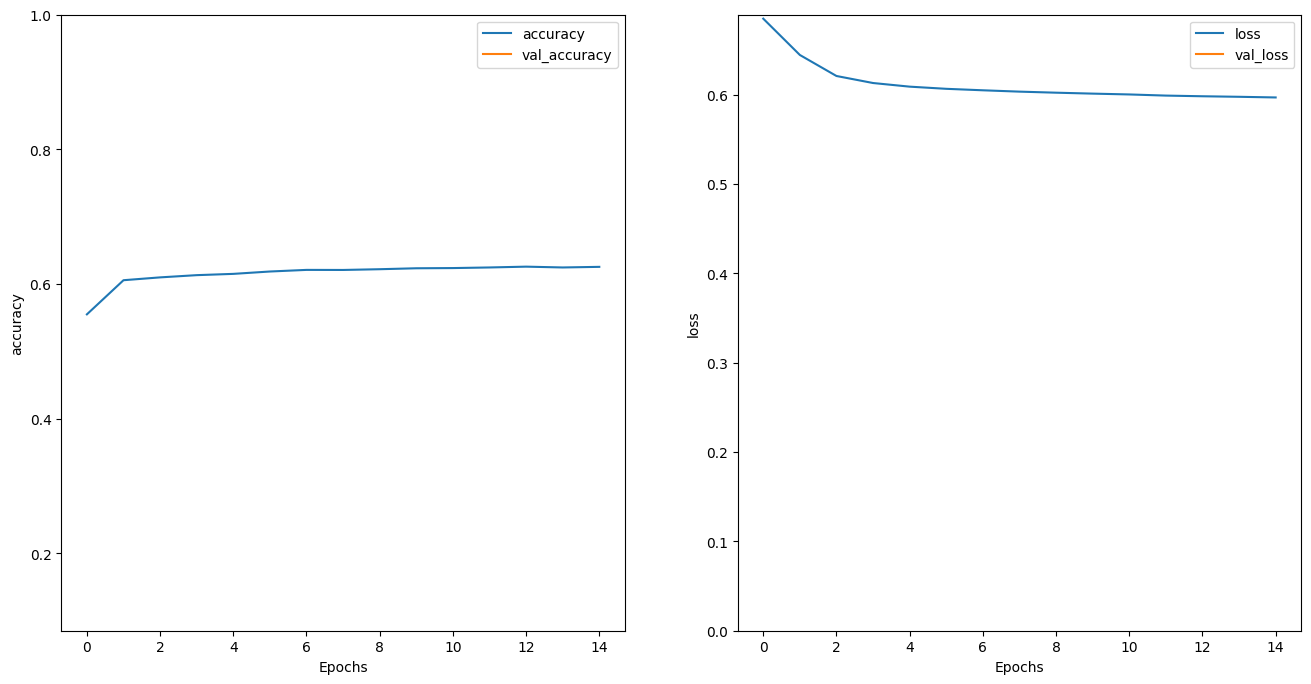

In [28]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [29]:
# predict on a sample text without padding
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[1.0821596]


##### Experiment 2: Use binary count vectorizer for encoding

In [30]:
model = create_model(encoder_multi_hot)
# predict on a sample formula using untrained model
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[0.02218796]


In [31]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=["accuracy"])

In [32]:
run = wandb.init(project="binary_precalculus_simple", reinit=True)
wandb.config = {
    "learning_rate": 1e-4,
    "optimizer": "adam",
    "epochs": 15,
    "batch_size": 64,
    "vectorizer": "multi_hot"
}

history = model.fit(train_dataset, epochs=15,
                    validation_data=test_dataset,
                    validation_steps=30,callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/15
156/156 [==============================] - ETA: 0s - loss: 0.6896 - accuracy: 0.5501WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 30 batches). You may need to use the repeat() function when building your dataset.


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_bin_classifiers/wandb/run-20221223_224510-2edi9v6g/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_bin_classifiers/wandb/run-20221223_224510-2edi9v6g/files/model-best/assets


156/156 [==============================] - 35s 194ms/step - loss: 0.6896 - accuracy: 0.5501 - val_loss: 0.7502 - val_accuracy: 0.0000e+00
Epoch 2/15
156/156 [==============================] - 11s 72ms/step - loss: 0.6721 - accuracy: 0.5744
Epoch 3/15
156/156 [==============================] - 10s 66ms/step - loss: 0.6636 - accuracy: 0.5909
Epoch 4/15
156/156 [==============================] - 11s 69ms/step - loss: 0.6630 - accuracy: 0.5900
Epoch 5/15
156/156 [==============================] - 9s 57ms/step - loss: 0.6626 - accuracy: 0.5921
Epoch 6/15
156/156 [==============================] - 9s 60ms/step - loss: 0.6627 - accuracy: 0.5909
Epoch 7/15
156/156 [==============================] - 10s 61ms/step - loss: 0.6624 - accuracy: 0.5909
Epoch 8/15
156/156 [==============================] - 11s 68ms/step - loss: 0.6621 - accuracy: 0.5910
Epoch 9/15
156/156 [==============================] - 9s 59ms/step - loss: 0.6622 - accuracy: 0.5915
Epoch 10/15
156/156 [============================

In [33]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

16/16 [==============================] - 0s 18ms/step - loss: 0.8106 - accuracy: 0.1200
Test Loss: 0.8106212019920349
Test Accuracy: 0.11999999731779099


(0.0, 0.7546414762735367)

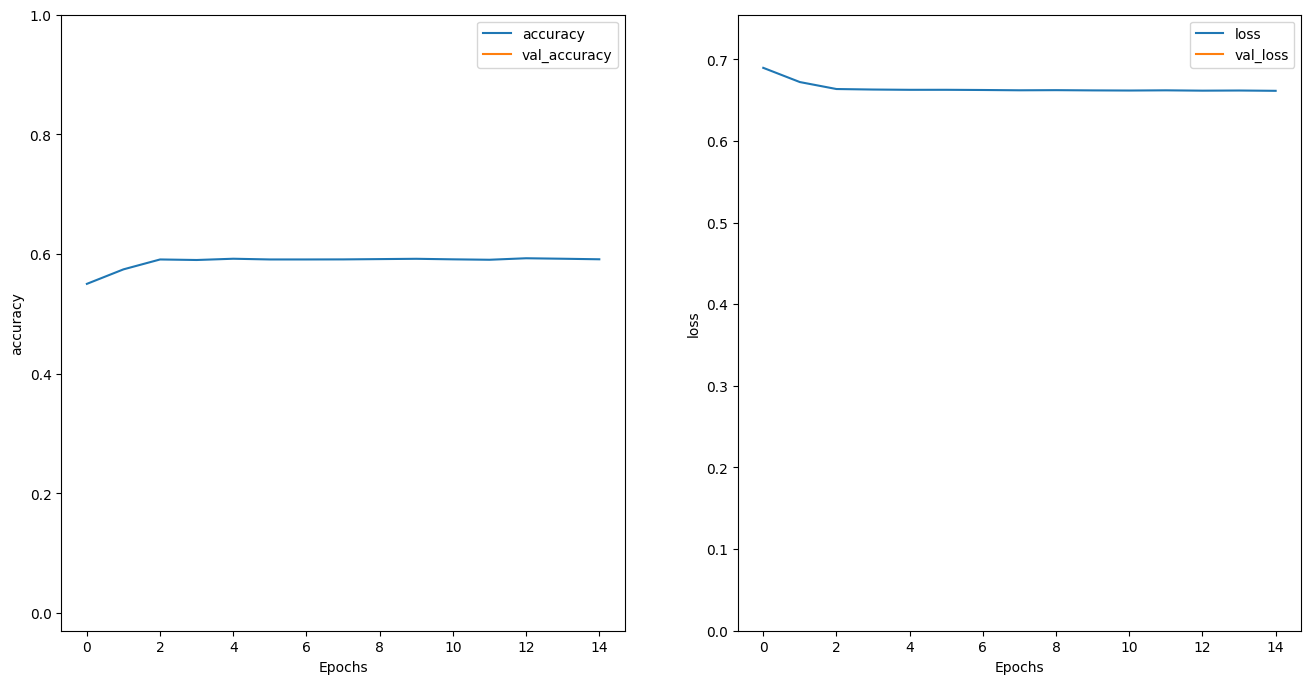

In [34]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [35]:
# predict on a sample text without padding
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[-0.28779832]


##### Experiment 3:

In [36]:
model = create_model(encoder_count)
# predict on a sample formula using untrained model
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 1s 1s/step
[0.01245196]


In [37]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=["accuracy"])

In [38]:
run = wandb.init(project="binary_precalculus_simple", reinit=True)
wandb.config = {
    "learning_rate": 1e-4,
    "optimizer": "adam",
    "epochs": 15,
    "batch_size": 64,
    "vectorizer": "count"
}

history = model.fit(train_dataset, epochs=15,
                    validation_data=test_dataset,
                    validation_steps=30,callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/15
156/156 [==============================] - ETA: 0s - loss: 0.6874 - accuracy: 0.5501WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 30 batches). You may need to use the repeat() function when building your dataset.


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_bin_classifiers/wandb/run-20221223_224836-1y580vwc/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_bin_classifiers/wandb/run-20221223_224836-1y580vwc/files/model-best/assets


156/156 [==============================] - 36s 186ms/step - loss: 0.6874 - accuracy: 0.5501 - val_loss: 0.7428 - val_accuracy: 0.0000e+00
Epoch 2/15
156/156 [==============================] - 11s 67ms/step - loss: 0.6644 - accuracy: 0.5799
Epoch 3/15
156/156 [==============================] - 11s 70ms/step - loss: 0.6558 - accuracy: 0.5962
Epoch 4/15
156/156 [==============================] - 12s 74ms/step - loss: 0.6548 - accuracy: 0.5962
Epoch 5/15
156/156 [==============================] - 11s 73ms/step - loss: 0.6541 - accuracy: 0.5970
Epoch 6/15
156/156 [==============================] - 11s 72ms/step - loss: 0.6538 - accuracy: 0.5975
Epoch 7/15
156/156 [==============================] - 13s 85ms/step - loss: 0.6534 - accuracy: 0.5987
Epoch 8/15
156/156 [==============================] - 11s 69ms/step - loss: 0.6534 - accuracy: 0.5977
Epoch 9/15
156/156 [==============================] - 12s 74ms/step - loss: 0.6529 - accuracy: 0.5985
Epoch 10/15
156/156 [=========================

In [39]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

16/16 [==============================] - 0s 18ms/step - loss: 0.7705 - accuracy: 0.1440
Test Loss: 0.7704628705978394
Test Accuracy: 0.14399999380111694


(0.0, 0.7473376840353012)

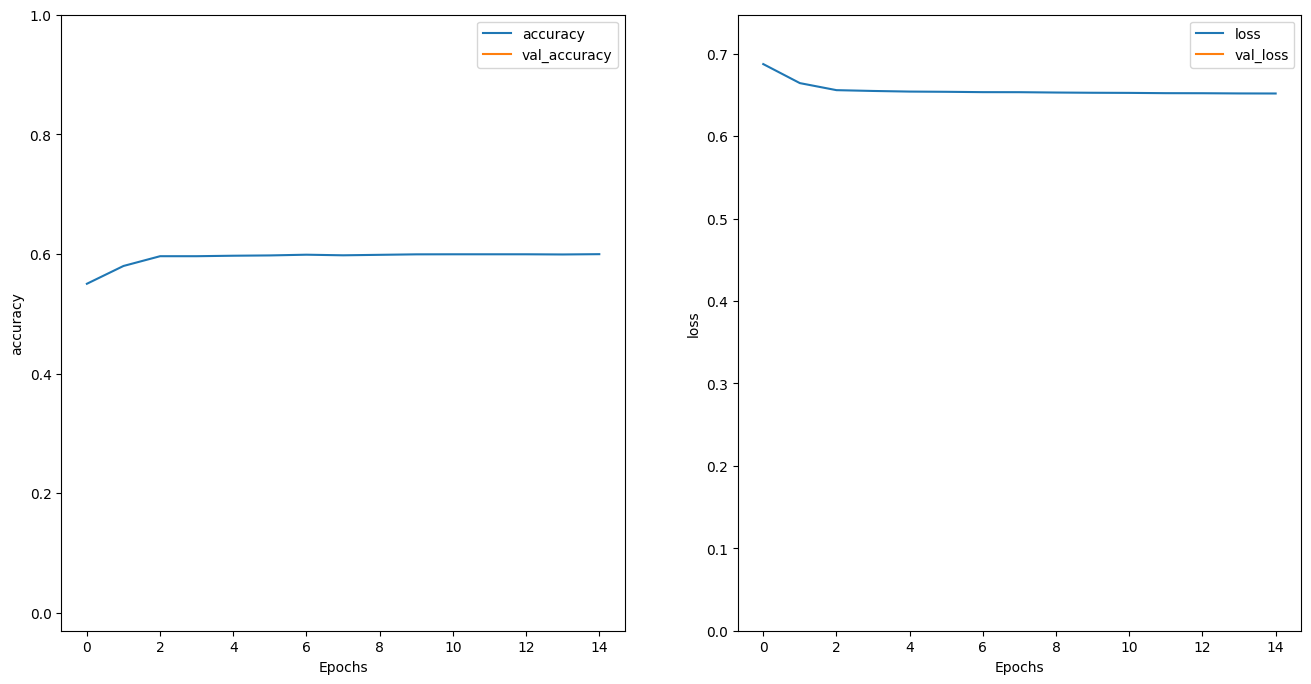

In [40]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [41]:
# predict on a sample text without padding
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[0.05676212]


##### Experiment 4:

In [42]:
model = create_model(encoder_bigrams)
# predict on a sample formula using untrained model
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 1s 1s/step
[-0.0374152]


In [43]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=["accuracy"])

In [44]:
run = wandb.init(project="binary_precalculus_simple", reinit=True)
wandb.config = {
    "learning_rate": 1e-4,
    "optimizer": "adam",
    "epochs": 15,
    "batch_size": 64,
    "vectorizer": "bigram_count"
}

history = model.fit(train_dataset, epochs=15,
                    validation_data=test_dataset,
                    validation_steps=30,callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/15
156/156 [==============================] - ETA: 0s - loss: 0.6845 - accuracy: 0.5506WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 30 batches). You may need to use the repeat() function when building your dataset.


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_bin_classifiers/wandb/run-20221223_225204-qy61cliy/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_bin_classifiers/wandb/run-20221223_225204-qy61cliy/files/model-best/assets


156/156 [==============================] - 113s 697ms/step - loss: 0.6845 - accuracy: 0.5506 - val_loss: 0.7368 - val_accuracy: 0.0700
Epoch 2/15
156/156 [==============================] - 94s 604ms/step - loss: 0.6582 - accuracy: 0.5921
Epoch 3/15
156/156 [==============================] - 97s 622ms/step - loss: 0.6557 - accuracy: 0.5959
Epoch 4/15
156/156 [==============================] - 99s 638ms/step - loss: 0.6550 - accuracy: 0.5983
Epoch 5/15
156/156 [==============================] - 94s 603ms/step - loss: 0.6544 - accuracy: 0.5987
Epoch 6/15
156/156 [==============================] - 91s 584ms/step - loss: 0.6540 - accuracy: 0.6000
Epoch 7/15
156/156 [==============================] - 94s 602ms/step - loss: 0.6535 - accuracy: 0.6004
Epoch 8/15
156/156 [==============================] - 90s 577ms/step - loss: 0.6533 - accuracy: 0.6004
Epoch 9/15
156/156 [==============================] - 95s 611ms/step - loss: 0.6532 - accuracy: 0.6005
Epoch 10/15
156/156 [====================

In [45]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

16/16 [==============================] - 3s 169ms/step - loss: 0.7377 - accuracy: 0.1600
Test Loss: 0.7376753687858582
Test Accuracy: 0.1599999964237213


(0.0, 0.7410760968923569)

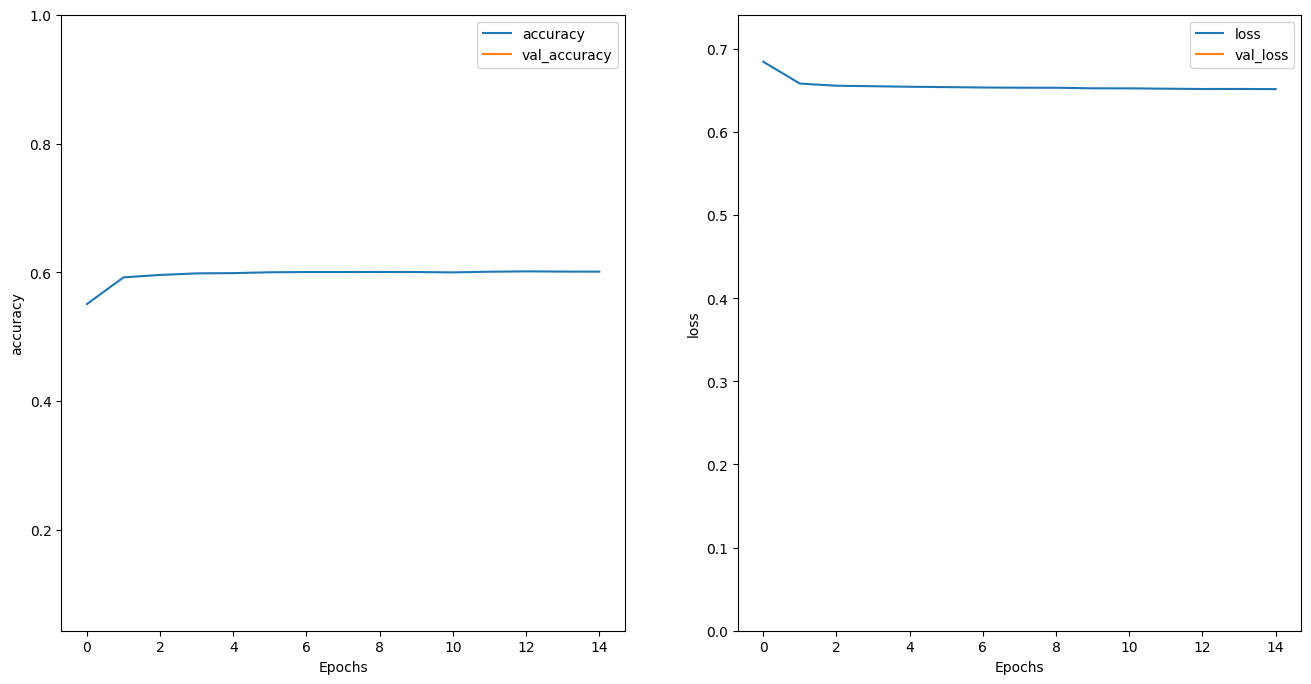

In [46]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [47]:
# predict on a sample text without padding
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[0.4348815]


##### Experiment 5:

In [48]:
model = create_model(encoder_tf_idf)
# predict on a sample formula using untrained model
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 4s 4s/step
[0.0140735]


In [49]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=["accuracy"])

In [50]:
run = wandb.init(project="binary_precalculus_simple", reinit=True)
wandb.config = {
    "learning_rate": 1e-4,
    "optimizer": "adam",
    "epochs": 15,
    "batch_size": 64,
    "vectorizer": "tf_idf"
}

history = model.fit(train_dataset, epochs=15,
                    validation_data=test_dataset,
                    validation_steps=30,callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/15
156/156 [==============================] - ETA: 0s - loss: 0.6888 - accuracy: 0.5501WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 30 batches). You may need to use the repeat() function when building your dataset.


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_bin_classifiers/wandb/run-20221223_231635-ailayjt5/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_bin_classifiers/wandb/run-20221223_231635-ailayjt5/files/model-best/assets


156/156 [==============================] - 36s 193ms/step - loss: 0.6888 - accuracy: 0.5501 - val_loss: 0.7261 - val_accuracy: 0.0000e+00
Epoch 2/15
156/156 [==============================] - 10s 61ms/step - loss: 0.6659 - accuracy: 0.5785
Epoch 3/15
156/156 [==============================] - 10s 61ms/step - loss: 0.6545 - accuracy: 0.5964
Epoch 4/15
156/156 [==============================] - 10s 61ms/step - loss: 0.6518 - accuracy: 0.5990
Epoch 5/15
156/156 [==============================] - 10s 63ms/step - loss: 0.6501 - accuracy: 0.5981
Epoch 6/15
156/156 [==============================] - 10s 63ms/step - loss: 0.6489 - accuracy: 0.6009
Epoch 7/15
156/156 [==============================] - 10s 63ms/step - loss: 0.6474 - accuracy: 0.6013
Epoch 8/15
156/156 [==============================] - 9s 60ms/step - loss: 0.6462 - accuracy: 0.6027
Epoch 9/15
156/156 [==============================] - 9s 59ms/step - loss: 0.6452 - accuracy: 0.6042
Epoch 10/15
156/156 [===========================

In [51]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

16/16 [==============================] - 0s 19ms/step - loss: 0.7419 - accuracy: 0.1720
Test Loss: 0.7419498562812805
Test Accuracy: 0.1720000058412552


(0.0, 0.7302557349205017)

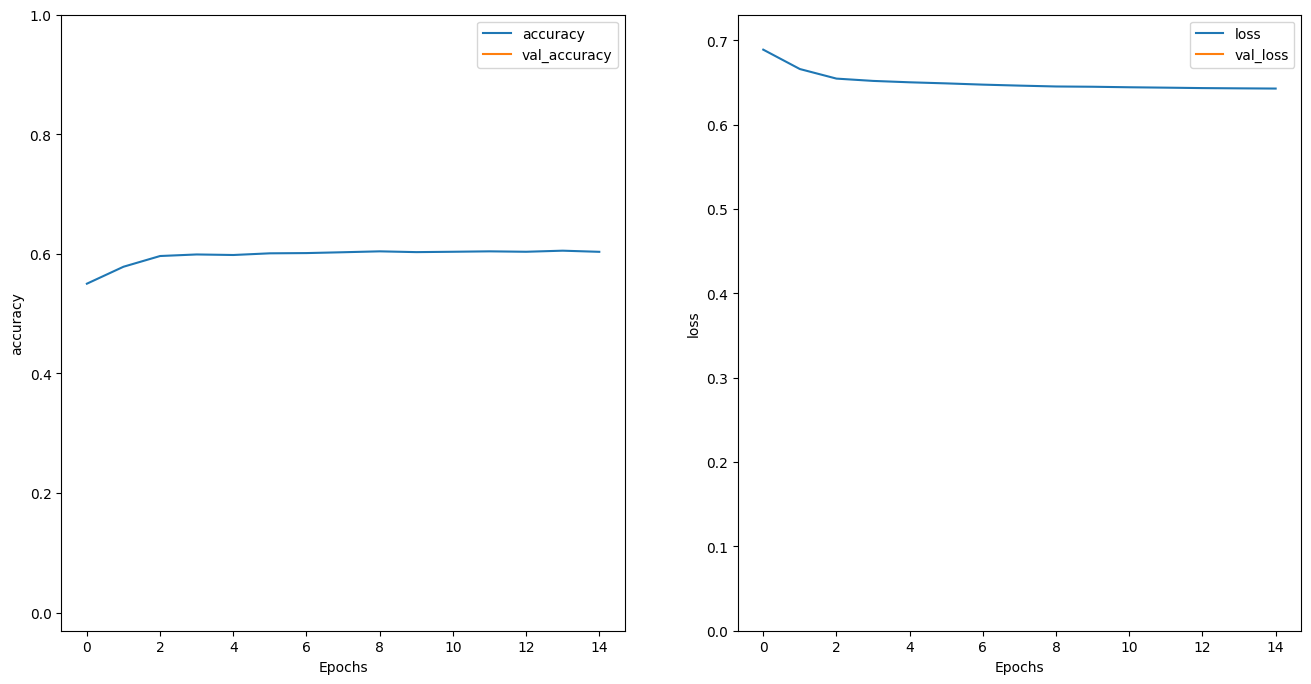

In [52]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [53]:
# predict on a sample text without padding
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[1.1033678]
